In [1]:
import math

import jax
import jax.numpy as jnp
import equinox as eqx
import matplotlib.pyplot as plt
import matplotlib as mpl

import event2vec.models as models
import event2vec.losses as losses
import event2vec.utils as utils

from event2vec.datasets import VBFHDataset
from event2vec.util import tril_to_matrix

import treescope
treescope.basic_interactive_setup()

In [2]:
from event2vec.training import TrainingConfig

In [3]:
data = VBFHDataset.from_lhe("../data/smeftsim_VBFH-*.lhe.gz")

Output()

LHE weight fit (rank 21) residuals mean: 9.948202201251477e-13 std: 5.530732122283055e-13


/Users/ncsmith/src/sbi4eft/event2vec/src/event2vec/datasets/lhedataset.py:241: UserWarning: Coefficient matrix is not positive semi-definite, negative eigenvalues: [-1.0845202e-05]
  latent_norm = QuadraticFormNormalization.from_coefficients(


In [4]:
input_shape = data.observables.shape[1:]
latent_shape = data.latent_data.shape[1:]

input_dim = math.prod(input_shape)

assert len(latent_shape) == 1
param_dim = int((jnp.sqrt(8 * latent_shape[0] + 1) - 1) / 2)

print(f"{input_shape = }\n{param_dim = }")

input_shape = (13,)
param_dim = 6


In [5]:
model_init_key = jax.random.key(1)
training_key = jax.random.key(2)

D_model_init_key, A_model_init_key = jax.random.split(model_init_key, 2)
D_training_key, A_training_key = jax.random.split(training_key, 2)

In [6]:
latent_matrix = tril_to_matrix(data.latent_data)
avg_latent_matrix = latent_matrix.mean(axis=0)

eigvals, eigvectors = jnp.linalg.eigh(avg_latent_matrix)

In [7]:
U_model = utils.ModelWrapper(eigvectors, is_static=True)

In [8]:
eps = 1e-6

reweights = jnp.empty((len(data.observables), param_dim))
for i in range(param_dim):
    reweights = reweights.at[:, i].set(
        jnp.sum(jnp.sum(latent_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1),
    )

log_reweights = jnp.log(jnp.clip(reweights, min=eps))

log_min = jnp.min(log_reweights, axis=0) - jnp.log(1.2)
log_max = jnp.max(log_reweights, axis=0) + jnp.log(1.2)

del reweights, log_reweights

In [ ]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim,),
    'hidden_widths': [16, 32, 32, 16],
    'hidden_activation': jax.nn.relu,
    'final_activation': models.activations.ExpAffineLogistic(log_min=log_min, log_max=log_max),
    'use_hidden_bias': True,
    'use_final_bias': True
}

untrained_D_model = models.MLP(**mlp_config, key=D_model_init_key)

In [10]:
mlp_config = {
    'in_shape': input_shape,
    'out_shape': (param_dim, param_dim),
    'hidden_widths': [64, 128, 128, 128, 64],
    'hidden_activation': jax.nn.relu,
    'final_activation': jax.nn.identity,
    'use_hidden_bias': True,
    'use_final_bias': True
}

untrained_A_model = models.MLP(**mlp_config, key=A_model_init_key)

In [ ]:
from event2vec.models.psd_matrix_models import PSDMatrixLLR
from event2vec.models.psd_matrix_models import U_sqrtD_At_A_sqrtD_Ut_Model

untrained_psd_matrix_model = PSDMatrixLLR(
    psd_matrix_model=U_sqrtD_At_A_sqrtD_Ut_Model(
        N = param_dim,
        U_model=U_model,
        D_model=untrained_D_model,
        A_model=untrained_A_model,
        normalize_A_cols=True
    ),
    normalization=data.normalization,
)

## Training only the D model

In [15]:
untrained_psd_matrix_model = utils.set_is_static_at(
    where=lambda x: x.psd_matrix_model.A_model,
    pytree=untrained_psd_matrix_model,
    is_static_value=True
)

In [16]:
loss = losses.psd_matrix_losses.DiagMSELoss()

In [17]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=256,
    learning_rate=0.001,
    epochs=200,
    loss_fn=loss
)

In [18]:
intermediate_psd_matrix_model, train_loss_history, test_loss_history = training_config.train(model=untrained_psd_matrix_model, data=data, key=D_training_key)

Output()

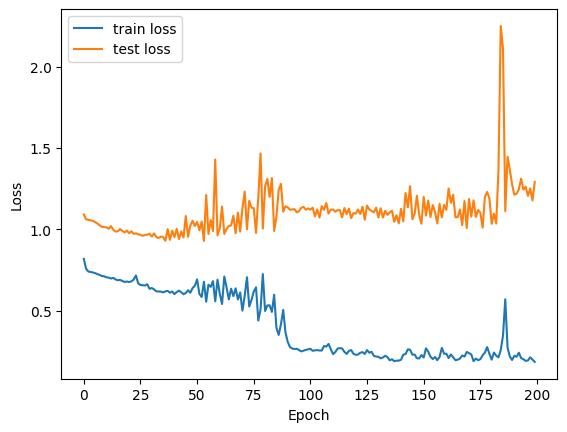

In [19]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
# ax.set_yscale('log')
ax.legend()

## Training both A and D models

In [20]:
intermediate_psd_matrix_model = utils.set_is_static_at(
    where=lambda x: x.psd_matrix_model.A_model,
    pytree=intermediate_psd_matrix_model,
    is_static_value=False
)

In [21]:
param_mean = jnp.zeros(param_dim).at[0].set(1)
param_cov = (jnp.eye(param_dim).at[0,0].set(0)) * 0.1

loss = losses.psd_matrix_losses.HyperQuadNormLoss(
    P_tensor=utils.mvn_fourth_moment(
        mean=param_mean,
        cov=param_cov,
        is_central=False
    )
)

In [22]:
training_config = TrainingConfig(
    test_fraction=0.2,
    batch_size=128,
    learning_rate=0.001,
    epochs=100,
    loss_fn=loss
)

In [23]:
trained_psd_matrix_model, train_loss_history, test_loss_history = training_config.train(model=intermediate_psd_matrix_model, data=data, key=A_training_key)

Output()

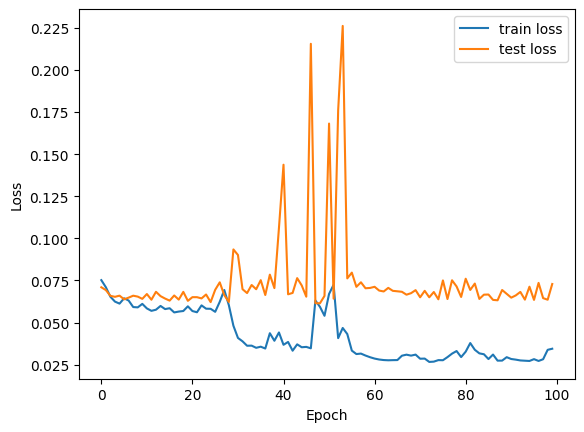

In [24]:
fig, ax = plt.subplots()

ax.plot(train_loss_history, label="train loss")
ax.plot(test_loss_history, label="test loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
# ax.set_ylim(0, 4)
ax.legend()

In [25]:
latent_matrix = tril_to_matrix(data.latent_data)

In [27]:
pred_matrix_before_training = jax.vmap(untrained_psd_matrix_model.psd_matrix)(data.observables)
pred_matrix = jax.vmap(trained_psd_matrix_model.psd_matrix)(data.observables)

In [28]:
latent_lengths = []
pred_lengths = []
pred_lengths_before_training = []

for i in range(6):
    latent_lengths.append(jnp.sum(jnp.sum(latent_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths.append(jnp.sum(jnp.sum(pred_matrix * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))
    pred_lengths_before_training.append(jnp.sum(jnp.sum(pred_matrix_before_training * eigvectors[:,i], axis=-1) * eigvectors[:,i], axis=-1))

latent_lengths = jnp.array(latent_lengths)
pred_lengths = jnp.array(pred_lengths)
pred_lengths_before_training = jnp.array(pred_lengths_before_training)

In [29]:
pred_lengths_before_training

Array([[9.9230801e-06, 1.0166760e-05, 1.0002785e-05, ..., 9.0360818e-06,
        1.0411598e-05, 1.0296625e-05],
       [2.9532300e-04, 3.0588915e-04, 3.6233052e-04, ..., 2.6338641e-04,
        3.2832500e-04, 3.4423944e-04],
       [1.4643177e-02, 1.6017640e-02, 1.8901218e-02, ..., 1.4075090e-02,
        1.8516589e-02, 1.7789517e-02],
       [9.6995877e-03, 8.3404444e-03, 6.3079298e-03, ..., 8.7539013e-03,
        4.4688899e-03, 5.6165522e-03],
       [4.9148477e-03, 5.2527566e-03, 5.4951380e-03, ..., 3.5461502e-03,
        4.9173092e-03, 6.2031485e-03],
       [6.7388785e-01, 6.6715997e-01, 6.4703000e-01, ..., 6.5919483e-01,
        6.4389169e-01, 6.4744413e-01]], dtype=float32)

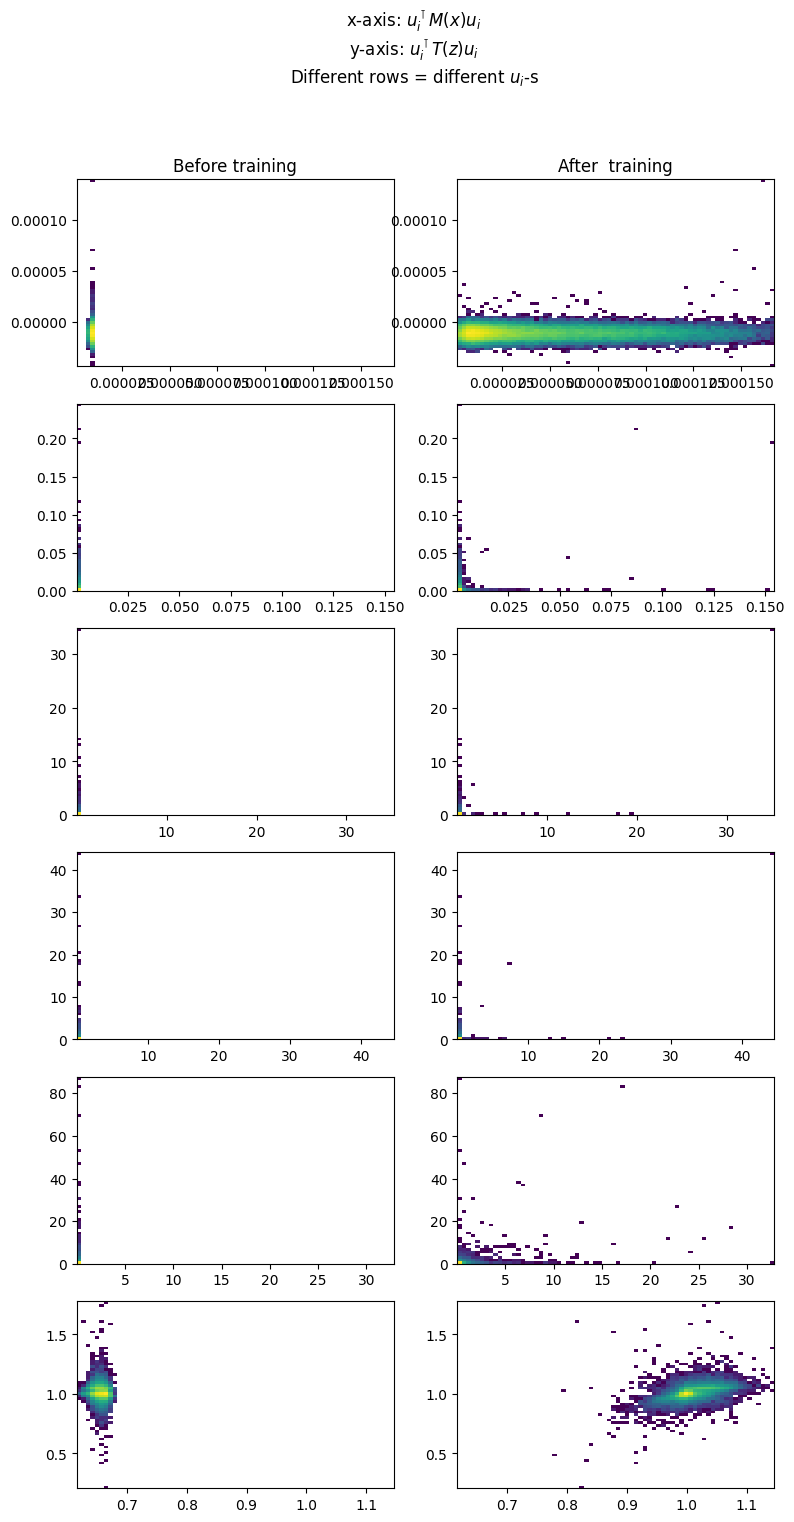

In [30]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(pred_lengths[i]), jnp.min(pred_lengths_before_training[i]))
    x_hi = max(jnp.max(pred_lengths[i]), jnp.max(pred_lengths_before_training[i]))

    y_lo = jnp.min(latent_lengths[i])
    y_hi = jnp.max(latent_lengths[i])
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(pred_lengths_before_training[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(pred_lengths[i], latent_lengths[i], range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $u_i^\\intercal M(x) u_i$ \ny-axis: $u_i^\\intercal T(z) u_i$\nDifferent rows = different $u_i$-s")

None

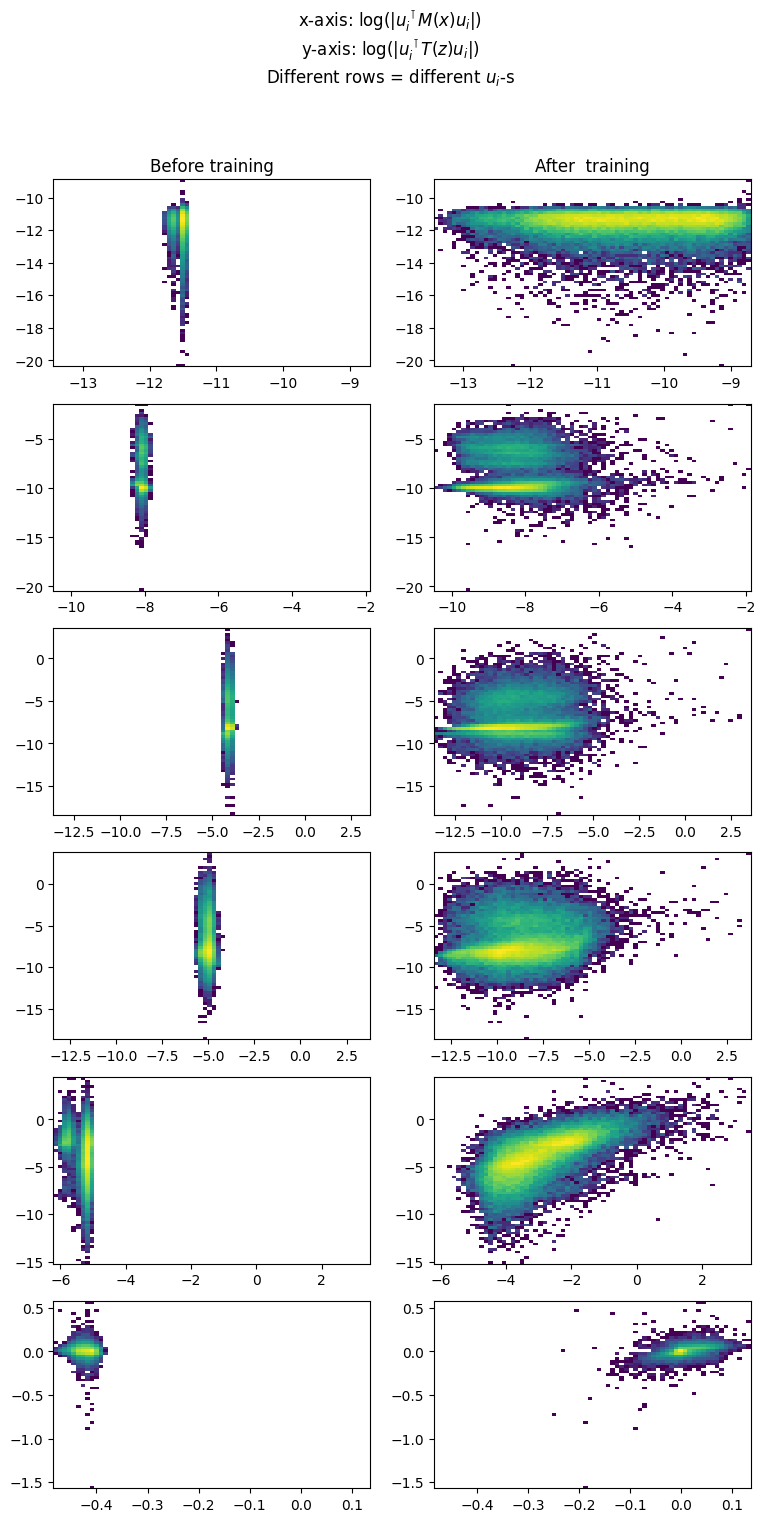

In [31]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(9, 17))

for i in range(6):
    x_lo = min(jnp.min(jnp.log(jnp.abs(pred_lengths[i]))), jnp.min(jnp.log(jnp.abs(pred_lengths_before_training[i]))))
    x_hi = max(jnp.max(jnp.log(jnp.abs(pred_lengths[i]))), jnp.max(jnp.log(jnp.abs(pred_lengths_before_training[i]))))

    y_lo = jnp.min(jnp.log(jnp.abs(latent_lengths[i])))
    y_hi = jnp.max(jnp.log(jnp.abs(latent_lengths[i])))
    
    for ax in axes[i]:
        ax.set_xlim(x_lo, x_hi)
        ax.set_ylim(y_lo, y_hi)

    axes[i][0].hist2d(jnp.log(jnp.abs(pred_lengths_before_training[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())
    axes[i][1].hist2d(jnp.log(jnp.abs(pred_lengths[i])), jnp.log(jnp.abs(latent_lengths[i])), range=((x_lo, x_hi), (y_lo, y_hi)), bins=70, norm=mpl.colors.LogNorm())

axes[0][0].set_title("Before training")
axes[0][1].set_title("After  training")

fig.suptitle("x-axis: $\\log(|u_i^\\intercal M(x) u_i|)$ \ny-axis: $\\log(|u_i^\\intercal T(z) u_i|)$\nDifferent rows = different $u_i$-s")

None

In [32]:
avg_pred_matrix_before_training = pred_matrix_before_training.mean(axis=0)
avg_pred_matrix = pred_matrix.mean(axis=0)

In [33]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix_before_training)

Array([ 3.56300503e-01+0.j,  1.14688784e-01+0.j,  1.76665168e-02+0.j,
       -5.76010253e-03+0.j, -2.00278082e-05+0.j,  6.01068488e-04+0.j],      dtype=complex64)

In [34]:
jnp.linalg.eigvals(avg_latent_matrix - avg_pred_matrix)

Array([ 2.1974279e-02+0.j,  1.3963488e-02+0.j, -4.8658936e-03+0.j,
        4.0989714e-03+0.j,  5.7891232e-04+0.j, -3.8612961e-05+0.j],      dtype=complex64)

In [35]:
alt_param = jnp.ones(param_dim).at[1:].set(
    jax.random.multivariate_normal(key=jax.random.key(0), mean=param_mean[1:], cov=param_cov[1:,1:])
)
print(alt_param)

[ 1.          0.5131245   0.64044493 -0.1371146  -0.02486099  0.05568483]


In [36]:
true_alt_reweights = jnp.sum(latent_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))
pred_alt_reweights = jnp.sum(pred_matrix * alt_param[:, None] * alt_param[None, :], axis=(-1, -2))

alt_param.tolist() = [1.0, 0.5131245255470276, 0.6404449343681335, -0.13711459934711456, -0.024860989302396774, 0.055684830993413925]


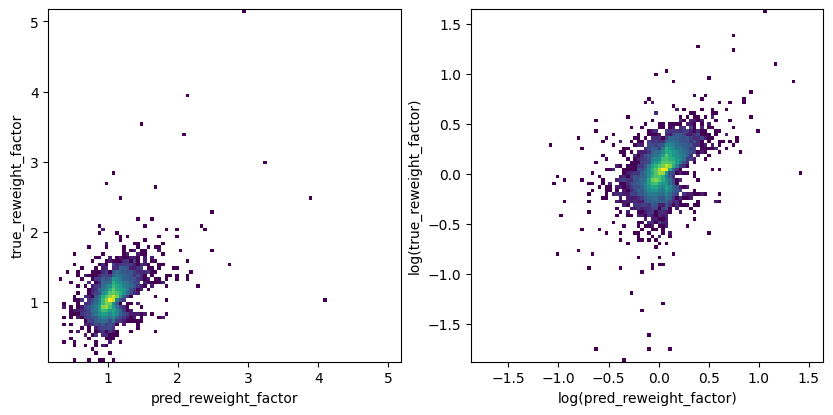

In [37]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))

lo = min(jnp.min(pred_alt_reweights), jnp.min(true_alt_reweights))
hi = max(jnp.max(pred_alt_reweights), jnp.max(true_alt_reweights))

axes[0].hist2d(pred_alt_reweights, true_alt_reweights, range=((lo, hi), (lo, hi)), bins=100, norm=mpl.colors.LogNorm())
axes[1].hist2d(jnp.log(pred_alt_reweights), jnp.log(true_alt_reweights), range=jnp.log(jnp.array(((lo, hi), (lo, hi)))), bins=100, norm=mpl.colors.LogNorm())

for ax in axes:
    ax.set_aspect('equal')

axes[0].set_xlabel('pred_reweight_factor')
axes[0].set_ylabel('true_reweight_factor')

axes[1].set_xlabel('log(pred_reweight_factor)')
axes[1].set_ylabel('log(true_reweight_factor)')

print(f"{alt_param.tolist() = }")

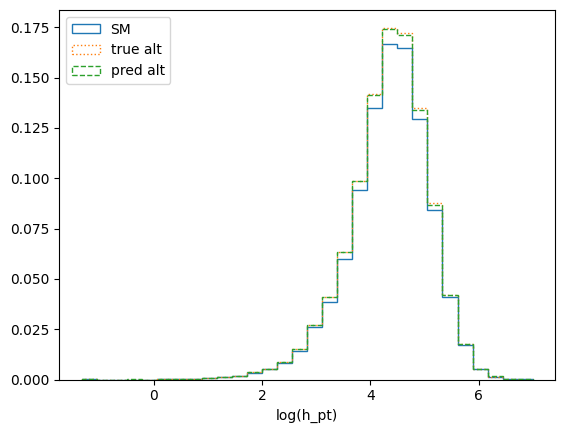

In [38]:
fig, ax = plt.subplots()

log_h_pt = data.observables[:,0]

bins=30
num_events = len(data.observables)

ax.hist(log_h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(log_h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("log(h_pt)")

ax.legend(loc=2)

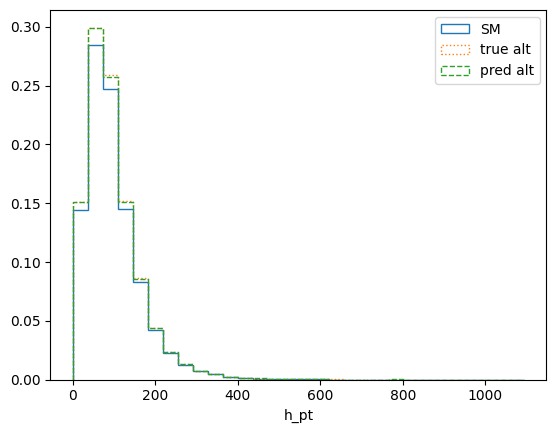

In [39]:
fig, ax = plt.subplots()

h_pt = jnp.exp(data.observables[:,0])

bins=30
num_events = len(data.observables)

ax.hist(h_pt, linestyle='solid', weights=jnp.ones(num_events)/num_events, label="SM", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dotted', weights=true_alt_reweights/num_events, label="true alt", histtype='step', bins=bins)
ax.hist(h_pt, linestyle='dashed', weights=pred_alt_reweights/num_events, label="pred alt", histtype='step', bins=bins)

ax.set_xlabel("h_pt")

ax.legend(loc=1)

In [ ]:
from pathlib import Path
from event2vec.models.psd_matrix_models import PSDMatrixLLR
from event2vec.prior import SMPlusNormalParameterPrior
from event2vec.analysis import run_analysis
from event2vec.training import MetricsHistory

In [41]:
llr_model = trained_psd_matrix_model

In [42]:
key = jax.random.key(42)
_, *points_keys = jax.random.split(key, 4)

prior = SMPlusNormalParameterPrior(
    mean = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0]),
    cov = jnp.diag(jnp.array([1.0e1, 1.0e1, 1.0e-1, 1.0e-1, 1.0e0]) * 10)
)

study_points = {
    "SM": jnp.array([1.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
    "rnd0": prior.sample(points_keys[0]),
    "rnd1": prior.sample(points_keys[1]),
    "rnd2": prior.sample(points_keys[2]),
}

In [43]:
run_analysis(
    model=llr_model,
    data=data,
    metrics=MetricsHistory(train_loss=train_loss_history, test_loss=test_loss_history),
    study_points=study_points,
    output_dir=Path("../matrix_regression_analysis_4/")
)

Output()